In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


### load packages

In [3]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [5]:
from tensorflow.keras.datasets import fashion_mnist

In [6]:
# load dataset
(train_images, Y_train), (test_images, Y_test) = fashion_mnist.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

print(len(X_train), len(X_valid))

50000 10000


In [7]:
[np.sum(Y_train == i) for i in np.unique(Y_train)]

[4977, 5012, 4992, 4979, 4950, 5004, 5030, 5045, 5032, 4979]

### define network

In [8]:
dims = (28,28,1)
n_components = 2

In [9]:
encoder = tf.keras.Sequential()
encoder.add(tf.keras.layers.InputLayer(input_shape=dims))
encoder.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=3, strides=1, padding="same", activation="relu"
))
encoder.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=3, strides=1, padding="same", activation="relu"
))
encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
encoder.add(tf.keras.layers.Dropout(0.25))
encoder.add(tf.keras.layers.Flatten())
encoder.add(tf.keras.layers.Dense(units=128, activation="relu"))
encoder.add(tf.keras.layers.Dropout(0.25))
encoder.add(tf.keras.layers.Dense(units=128, activation="relu"))
encoder.add(tf.keras.layers.Dense(n_components, activation=None, name='z'))

### Save initial weights

In [10]:
from tfumap.paths import MODEL_DIR, ensure_dir

In [11]:
??embedder

Object `embedder` not found.


In [12]:
embedder = tfUMAP(
    training_epochs=5,
    max_sample_repeats_per_epoch=10,
    train_classifier=True,
    valid_X = X_valid,
    valid_Y = Y_valid,
    verbose=True,
    dims=dims,
    n_components=n_components,
    encoder=encoder,
    target_weight=1.0,
    umap_loss_weight = 1.0,
    optimizer = tf.keras.optimizers.RMSprop(1e-3),
)

In [13]:
initial_weights = embedder.encoder.get_weights()
# embedder.encoder.set_weights(initial_weights)

### train

In [14]:
import pickle
import os

In [15]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [16]:
training_exemplars_per_class = np.logspace(0,12,base=2, num=11).astype('int')
training_exemplars_per_class

array([   1,    2,    5,   12,   27,   64,  147,  337,  776, 1782, 4096])

tfUMAP(dims=(28, 28, 1),
       encoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f60505aff98>,
       max_sample_repeats_per_epoch=10, negative_sample_rate=5,
       optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f5e9456d320>,
       tensorboard_logdir='/tmp/tensorboard/20200706-141702',
       train_classifier=True, training_epochs=5, umap_loss_weight=0.0,
       valid_X=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
       valid_Y=array([9, 2, 1, ..., 3, 0, 5], dtype=uint8))
Construct fuzzy simplicial set
Mon Jul  6 14:17:02 2020 Finding Nearest Neighbors
Mon Jul  6 14:17:03 2020 Building RP forest with 16 trees
Mon Jul  6 14:17:03 2020 parallel NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
Mon Jul  6 

Mon Jul  6 14:40:09 2020 Finished embedding
Pickle of model saved


I0706 14:40:19.850427 140054644991808 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/semisupervised/fmnist/joint-loss/1/encoder/assets


Encoder Keras model saved


I0706 14:40:20.175714 140054644991808 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/semisupervised/fmnist/joint-loss/1/classifier/assets


Classifier Keras model saved
['umap_loss', 'classif_loss', 'classif_acc']
['classif_loss', 'classif_acc']


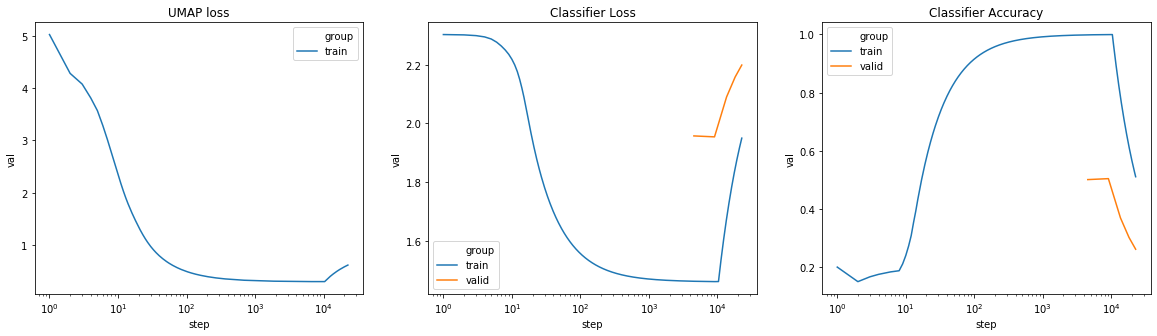

tf.Tensor(0.1, shape=(), dtype=float32)
tfUMAP(dims=(28, 28, 1),
       encoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f60505aff98>,
       max_sample_repeats_per_epoch=10, negative_sample_rate=5,
       optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f5edc186ba8>,
       tensorboard_logdir='/tmp/tensorboard/20200706-144023',
       train_classifier=True, training_epochs=5, umap_loss_weight=0.0,
       valid_X=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
       valid_Y=array([9, 2, 1, ..., 3, 0, 5], dtype=uint8))
Construct fuzzy simplicial set
Mon Jul  6 14:40:24 2020 Finding Nearest Neighbors
Mon Jul  6 14:40:24 2020 Building RP forest with 16 trees
Mon Jul  6 14:40:24 2020 parallel NN descent for 16 iterations
	 0  /  16
	 1 

Mon Jul  6 15:03:28 2020 Finished embedding
Pickle of model saved


I0706 15:03:38.699993 140054644991808 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/semisupervised/fmnist/joint-loss/2/encoder/assets


Encoder Keras model saved


I0706 15:03:39.101446 140054644991808 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/semisupervised/fmnist/joint-loss/2/classifier/assets


Classifier Keras model saved
['umap_loss', 'classif_loss', 'classif_acc']
['classif_loss', 'classif_acc']


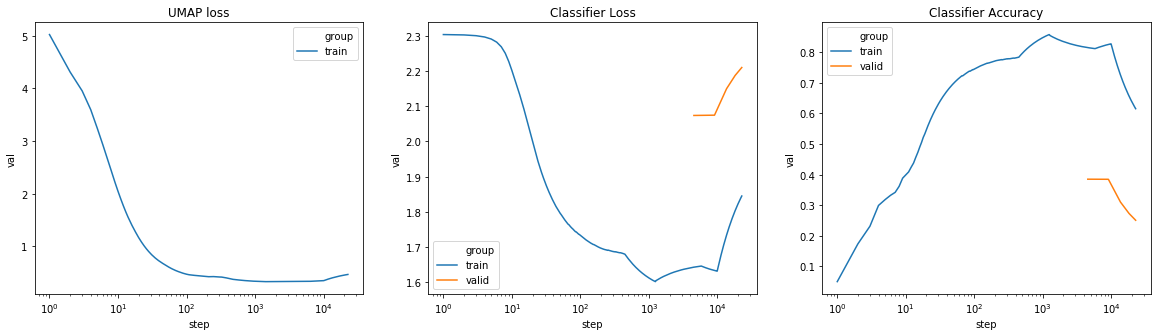

tf.Tensor(0.1653, shape=(), dtype=float32)
tfUMAP(dims=(28, 28, 1),
       encoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f60505aff98>,
       max_sample_repeats_per_epoch=10, negative_sample_rate=5,
       optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f5ea87daa20>,
       tensorboard_logdir='/tmp/tensorboard/20200706-150342',
       train_classifier=True, training_epochs=5, umap_loss_weight=0.0,
       valid_X=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
       valid_Y=array([9, 2, 1, ..., 3, 0, 5], dtype=uint8))
Construct fuzzy simplicial set
Mon Jul  6 15:03:43 2020 Finding Nearest Neighbors
Mon Jul  6 15:03:43 2020 Building RP forest with 16 trees
Mon Jul  6 15:03:43 2020 parallel NN descent for 16 iterations
	 0  /  16
	

Mon Jul  6 15:26:55 2020 Finished embedding
Pickle of model saved


I0706 15:27:07.174731 140054644991808 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/semisupervised/fmnist/joint-loss/5/encoder/assets


Encoder Keras model saved


I0706 15:27:07.514959 140054644991808 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/semisupervised/fmnist/joint-loss/5/classifier/assets


Classifier Keras model saved
['umap_loss', 'classif_loss', 'classif_acc']
['classif_loss', 'classif_acc']


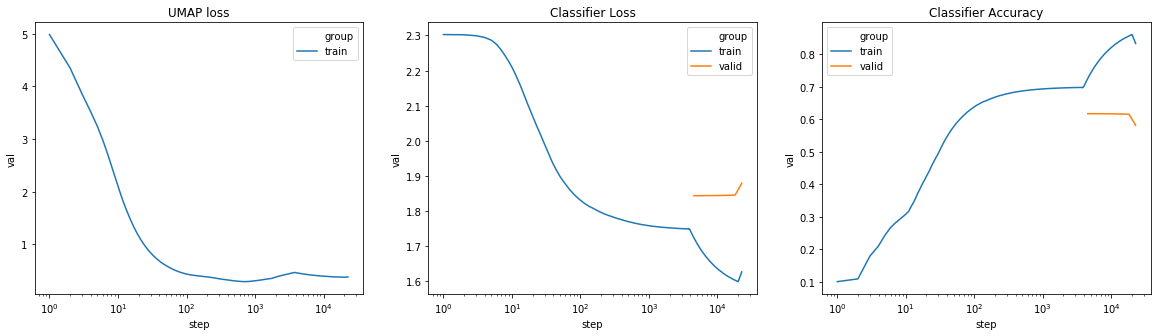

tf.Tensor(0.446, shape=(), dtype=float32)
tfUMAP(dims=(28, 28, 1),
       encoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f60505aff98>,
       max_sample_repeats_per_epoch=10, negative_sample_rate=5,
       optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f5f78720208>,
       tensorboard_logdir='/tmp/tensorboard/20200706-152711',
       train_classifier=True, training_epochs=5, umap_loss_weight=0.0,
       valid_X=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
       valid_Y=array([9, 2, 1, ..., 3, 0, 5], dtype=uint8))
Construct fuzzy simplicial set
Mon Jul  6 15:27:11 2020 Finding Nearest Neighbors
Mon Jul  6 15:27:11 2020 Building RP forest with 16 trees
Mon Jul  6 15:27:12 2020 parallel NN descent for 16 iterations
	 0  /  16
	 

In [ ]:
for n_training in tqdm(training_exemplars_per_class):
    # mask labels
    label_mask = np.concatenate([np.where(Y_train == i)[0][:n_training] for i in np.unique(Y_train)])
    Y_train_masked = np.ones(len(Y_train))*-1
    Y_train_masked[label_mask] = Y_train[label_mask]
    
    tf.keras.backend.clear_session()
    # re-initialize network
    embedder = tfUMAP(
        training_epochs=5,
        max_sample_repeats_per_epoch=10,
        train_classifier=True,
        valid_X = X_valid,
        valid_Y = Y_valid,
        verbose=True,
        dims=dims,
        n_components=n_components,
        encoder=encoder,
        target_weight=1.0,
        umap_loss_weight = 0.0
    )
    embedder.encoder.set_weights(initial_weights)
    
    # train
    z = embedder.fit_transform(X_train, y=Y_train_masked)
    
    # save network output
    output_dir = MODEL_DIR / 'semisupervised' / 'fmnist' / 'joint-loss' / str(n_training)
    ensure_dir(output_dir)
    embedder.save(output_dir)
    
    
    # plot losses
    loss_df = retrieve_tensors(embedder.tensorboard_logdir)
    fig, axs = plt.subplots(ncols=3, figsize=(20,5))
    ax = axs[0]
    sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='umap_loss'], ax = ax, ci=None)
    ax.set_xscale('log')
    ax.set_title('UMAP loss')

    ax = axs[1]
    sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='classif_loss'], ax = ax, ci=None)
    ax.set_xscale('log')
    ax.set_title('Classifier Loss')

    ax = axs[2]
    sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='classif_acc'], ax = ax, ci=None)
    ax.set_xscale('log')
    ax.set_title('Classifier Accuracy')
    plt.show()
    
    #compute loss on test data
    X = X_test
    Y = Y_test
    # get output of last layer
    n_batches = np.ceil(len(X) / embedder.batch_size).astype(int)
    if len(embedder.dims) > 1:
        X = np.reshape(X, [len(X)] + list(embedder.dims))

    predictions = []
    for batch in np.arange(n_batches):
        predictions.append(
            embedder.classifier(embedder.encoder_base(
                X[(batch * embedder.batch_size) : ((batch + 1) * embedder.batch_size)]
            )).numpy()
        )
    predictions = np.vstack(predictions)
    np.shape(predictions)
    acc = tf.reduce_mean(tf.keras.metrics.sparse_categorical_accuracy(tf.Variable(Y), predictions))
    top_1 = np.argmax(predictions, axis=1)

    print(acc)

In [ ]:
# 4534

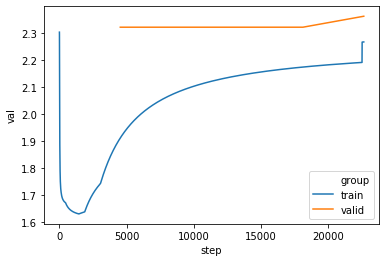

In [18]:
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='classif_loss'], ci=None)